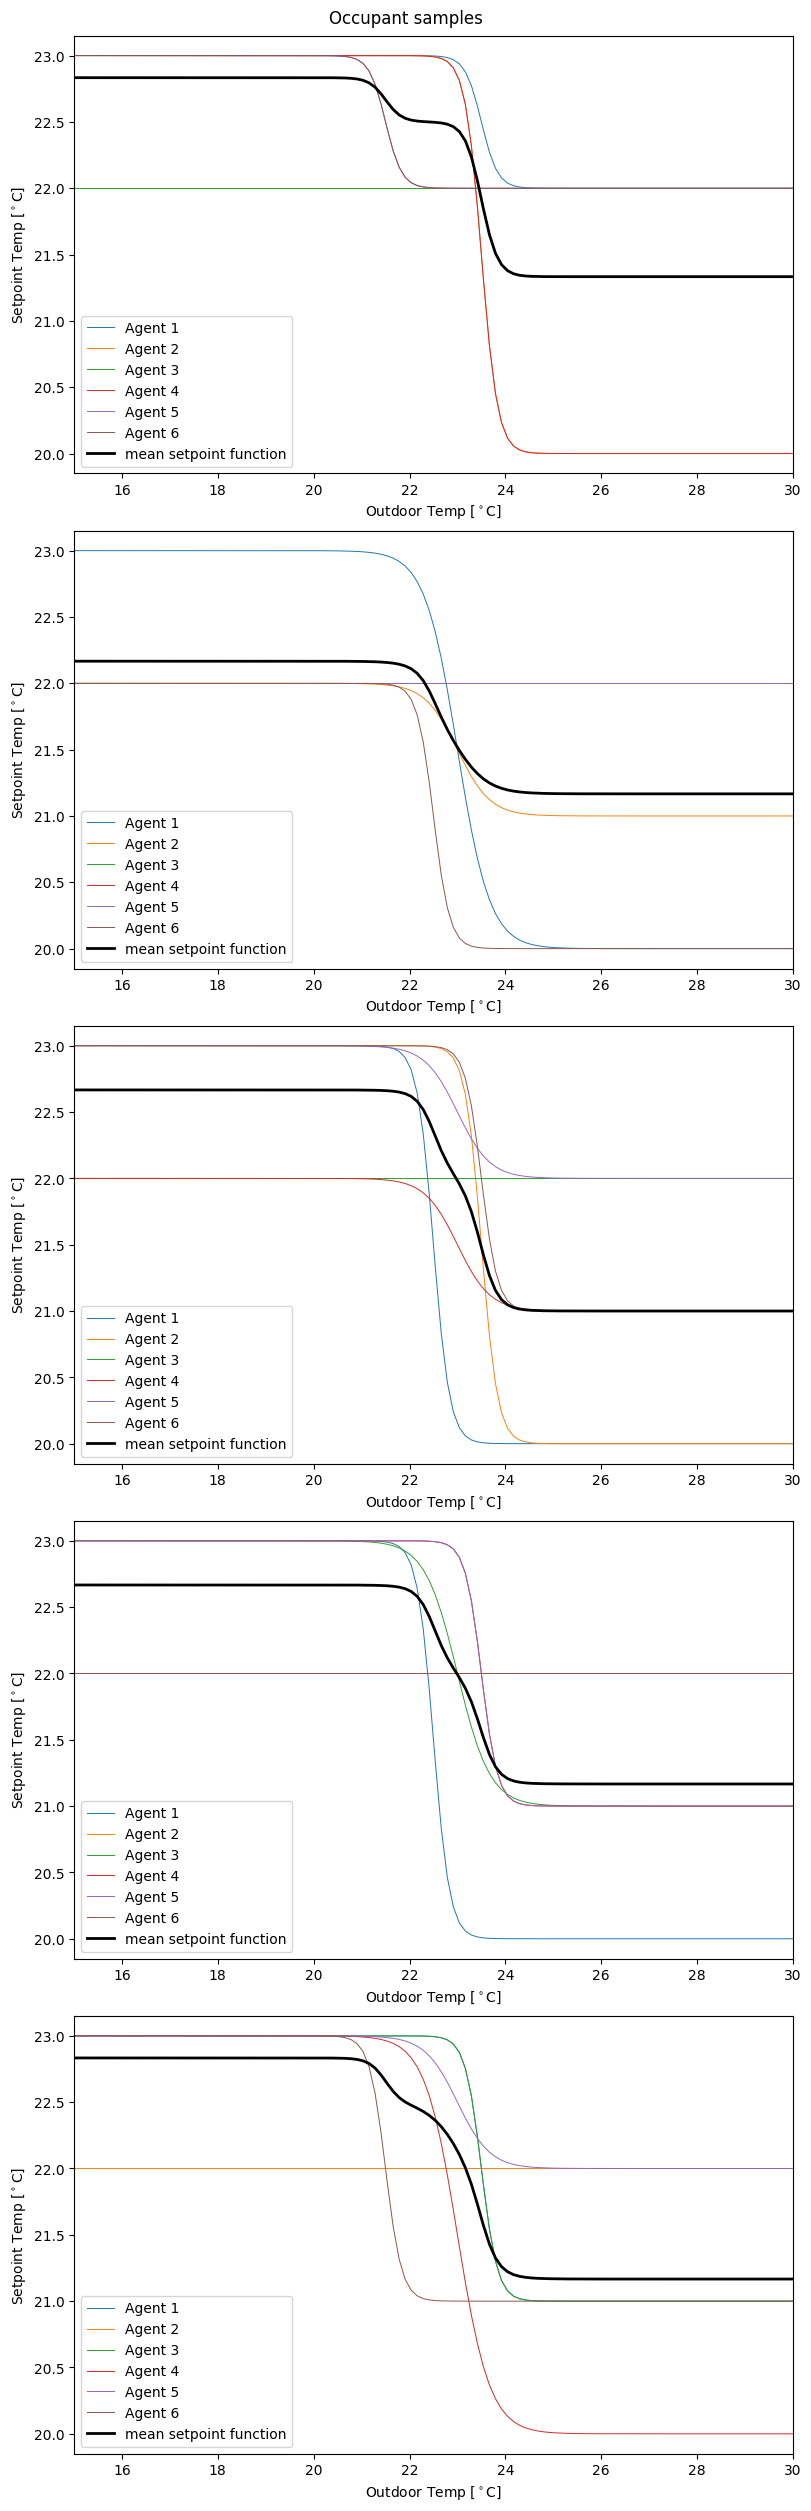

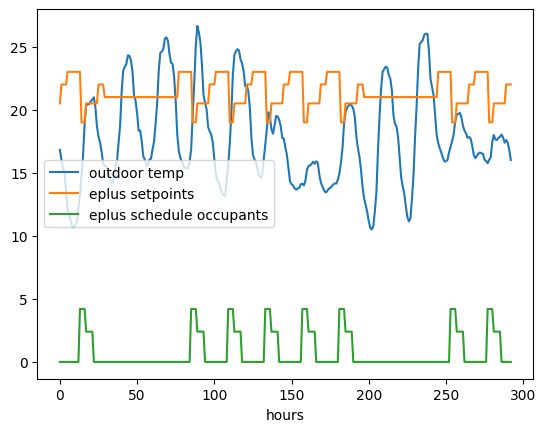

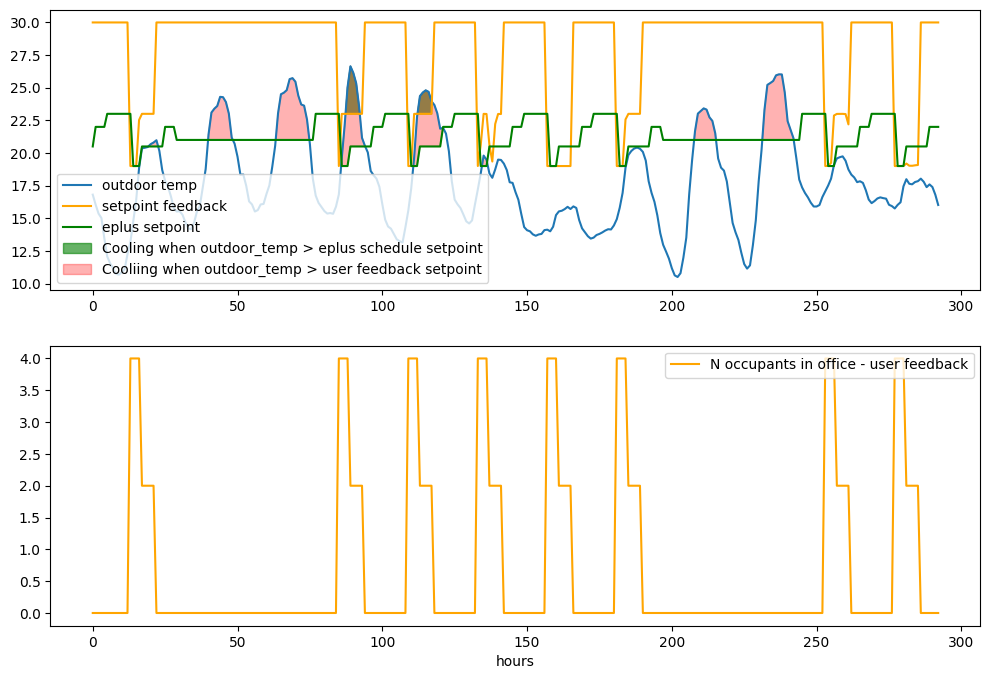

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas

# class and function definitions

def sigmoid(x, a=0, k=1):
    return (1 / (1 + np.exp(-k * (x - a))))


def get_steepness(y, x):
    k = - np.log((1 / y) - 1) / x
    return k


def scale_outdoor_temp(t, min_temp, max_temp, to_interval=(-1, 1)):
    int_min, int_max = to_interval
    t_scaled = (t - min_temp) / (max_temp - min_temp) * (int_max - int_min) + int_min
    return t_scaled


class Agent:
    def __init__(self, setpoint_low=(20.0, 20.0),
                 setpoint_high=(24.0, 20.00)):  # ab 23 grad wird der setpoint auf 20 grad gesetzt
        """Occupant class for setpoint feedback.

        Args:
            setpoint_low (outdoor_temperature, setpoint): Lower limit of cooling setpoint. Indicates
                the outdoor_temperature at which the highest cooling setpoint (= weakest cooling) should be returned.
            setpoint_high (outdoor_temperature, setpoint): Upper limit of cooling setpoint. Indicates
                the outdoor_temperature at which the lowest cooling setpoint (= strongest cooling) should be returned.

        """

        self.temp_out_low, self.cooling_low = setpoint_low
        self.temp_out_high, self.cooling_high = setpoint_high
        self.scale_interval = (self.temp_out_low, self.temp_out_high)
        self.k = get_steepness(0.95, 1)

    def setpoint_feedback(self, outside_temp):
        # x = scale_outdoor_temp(outside_temp, self.tmin, self.tmax)
        x = scale_outdoor_temp(outside_temp, self.temp_out_low, self.temp_out_high)
        return self._get_setpoint(x)

    def _get_setpoint(self, x):
        y = sigmoid(x, k=self.k) * (-1)
        y = self._scale_setpoint(y)
        return y

    def _scale_setpoint(self, y):
        x_min, x_max = (-1, 0)
        min, max = (self.cooling_high, self.cooling_low)
        y_scaled = (y - x_min) / (x_max - x_min) * (max - min) + min
        return y_scaled


class Office:
    def __init__(self, occupants):
        """Helper class to get combined feedback from multiple occupants.

        Args:
            occupants: List of occupants from class Agent.
        """

        self.occupants = occupants

    def get_combined_feedback(self, outside_temp, occupants_idx):
        """Returns combined setpoint feedback (simple mean).

        Args:
            outside_temp: Current outside temperature
            occupants_idx (_type_): Indices of occupants from occupants list currently in the office.

        Returns:
            Mean setpoint feedback.
        """
        if occupants_idx is None or occupants_idx == 0:
            return 30
        else:
            setpoint_feedback = 0
            for i in occupants_idx:
                setpoint_feedback += self.occupants[i].setpoint_feedback(outside_temp)
            return setpoint_feedback / len(occupants_idx)

    def get_single_feedback(self, outside_temp, occupants_amount):
        """Returns setpoint feedback for a single occupant.

        Args:
            outside_temp: Current outside temperature
            occupants_amount (_type_): Number of occupants in the office.

        Returns:
            Setpoint feedback for a single occupant.
        """
        if occupants_amount == 0:
            return 30
        return self.occupants[0].setpoint_feedback(outside_temp)


# Occupancy
# function
# example
# outdoor temp limits
tmin = 15  # darunter keine kühlung
tmax = 40

n_eval = 200
n_occupants = 6

occupants_setpoints = np.zeros((n_occupants, n_eval))

# outdoor temperature array
outdoor_temp = np.linspace(tmin, tmax, n_eval)

n_samples = 5
fig, ax = plt.subplots(5, 1, figsize=(8, 5 * n_samples), layout="constrained")
for i in range(n_samples):
    for j in range(n_occupants):
        # occupant setpoint samples
        temp_low = np.random.choice(np.arange(21, 24))  # ab wann will er das gekühlt wird
        cooling_low = np.random.choice(np.arange(22, 24))  # was ist sein ziel setpoint
        temp_high = np.random.choice(np.arange(temp_low + 1, 25))
        cooling_high = np.random.choice(np.arange(20, 23))

        # generate occupant agent
        o = Agent(setpoint_low=(temp_low, cooling_low), setpoint_high=(temp_high, cooling_high))
        # get setpoint
        setpoints = o.setpoint_feedback(outdoor_temp)

        occupants_setpoints[j] = setpoints
        ax[i].plot(outdoor_temp, setpoints, label=f"Agent {j + 1}", linewidth=.7)
    ax[i].plot(outdoor_temp, occupants_setpoints.mean(axis=0), "black", linewidth=2, label="mean setpoint function")
    ax[i].set_ylabel(r"Setpoint Temp [$^\circ$C]")
    ax[i].set_xlabel(r"Outdoor Temp [$^\circ$C]")
    ax[i].set_xlim(15, 30)
    ax[i].legend()
fig.suptitle('Occupant samples')
# fig.tight_layout()
plt.show()
# Office


# class example


# real temperatures
df_sim_real = pandas.read_csv('final_office_IdealLoad_summer_tiny_hourly_own_schedule_24_final_2.csv', header=0,
                              index_col=0)
df_sim_real = df_sim_real.drop(
    labels='THERMAL ZONE 1:Zone Thermal Comfort ASHRAE 55 Simple Model Summer Clothes Not Comfortable Time [hr](Hourly)',
    axis=1)
# last 293 rows of df_sim_real = test data from 2022-08-18 20:00:00 to 2022-08-30 24:00:00
df_sim_real_test = df_sim_real.tail(293)
outdoor_temp = df_sim_real_test['Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)'].values
sim_real_data_setpoints = df_sim_real_test[
    'THERMAL ZONE 1:Zone Thermostat Cooling Setpoint Temperature [C](Hourly)'].values
sim_real_data_occupants = df_sim_real_test['THERMAL ZONE 1:Zone People Occupant Count [](Hourly)'].values

plt.plot(outdoor_temp, label="outdoor temp")
plt.plot(sim_real_data_setpoints, label="eplus setpoints")
plt.plot(sim_real_data_occupants, label="eplus schedule occupants")
# x label
plt.xlabel('hours')
plt.legend()
plt.show()

# outdoor temp limits
tmin = 15
tmax = 30

n_eval = 293
n_occupants = 6

# outdoor temperature array --> replaced with real outdoor temperature data (see above)
# outdoor_temp = np.linspace(tmin, tmax, n_eval)
occupants_list = []

for j in range(n_occupants):
    # occupant setpoint samples
    temp_low = np.random.choice(np.arange(17, 21))
    cooling_low = np.random.choice(np.arange(19, 22.5))
    temp_high = np.random.choice(np.arange(temp_low + 1, 22))
    cooling_high = np.random.choice(np.arange(18, 23.5))

    # generate occupant agent
    o = Agent(setpoint_low=(temp_low, cooling_low), setpoint_high=(temp_high, cooling_high))
    occupants_list.append(o)

office = Office(occupants_list)

# generate outdoor temperature trajectory
# outdoor temperature array --> replaced with real outdoor temperature data (see above)
# outdoor_temp = np.sin(np.linspace(-np.pi, np.pi, 100)) + 20 + np.random.randn(100) * 0.1
eval_interval = 1  #evaluation interval

feedback_t = []
num_occupants_t = []
sim_occupants = sim_real_data_occupants.astype(int).tolist()  # list(sim_real_data_occupants)

counter = 0
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
for t in outdoor_temp[::eval_interval]:
    # print(t)
    #select random occupants in office
    n_occupants_in_office = np.random.randint(0, len(occupants_list) + 1)
    # sim_occupant_at_t = int(sim_occupants[int(t)])
    # occupants_in_office = sim_occupant_at_t
    occupants_in_office = np.random.choice(np.arange(len(occupants_list)), size=n_occupants_in_office, replace=False)
    # y = office.get_combined_feedback(t, occupants_in_office)
    # y = office.get_combined_feedback(t, sim_occupants[counter])
    y = office.get_single_feedback(t, sim_occupants[counter])
    counter += 1
    feedback_t.extend([y] * eval_interval)
    # num_occupants_t.extend([n_occupants_in_office]*eval_interval)
    num_occupants_t = sim_occupants

ax[0].plot(outdoor_temp, label="outdoor temp")
ax[0].plot(feedback_t, color='orange', label="setpoint feedback")
ax[0].plot(sim_real_data_setpoints, color='green', label="eplus setpoint")
ax[0].fill_between(range(len(outdoor_temp)), outdoor_temp, feedback_t, where=(feedback_t < outdoor_temp),
                   interpolate=True, color='green', alpha=0.6,
                   label='Cooling when outdoor_temp > eplus schedule setpoint')
ax[0].fill_between(range(len(outdoor_temp)), outdoor_temp, sim_real_data_setpoints,
                   where=(sim_real_data_setpoints < outdoor_temp), interpolate=True, color='red', alpha=0.3,
                   label='Cooliing when outdoor_temp > user feedback setpoint')
ax[0].legend()
ax[1].plot(num_occupants_t, color="orange", label="N occupants in office - user feedback")
# ax[1].plot(sim_real_data_occupants, color="black", label="N occupants in office - eplus")
plt.xlabel('hours')
ax[1].legend()

plt.show()
# save feedback to csv
df_feedback = pandas.DataFrame(feedback_t, columns=["setpoint_feedback"])
df_feedback["num_occupants_user_feedback"] = num_occupants_t
df_feedback.to_csv("user_feedback_test.csv")
# concat user feedback to oringal data set and save to csv file for further analysis


In [2]:
# plot the cooling load (area between outdoor temp and setpoint feedback + eplus setpoint) in bar plot for each hour
# to see the difference between the two cooling loads
# fig, ax = plt.subplots(2, 1, figsize=(12, 8))

cooling_load_user_feedback = np.maximum(outdoor_temp - feedback_t, 0)
cooling_load_eplus = np.maximum(outdoor_temp - sim_real_data_setpoints, 0)


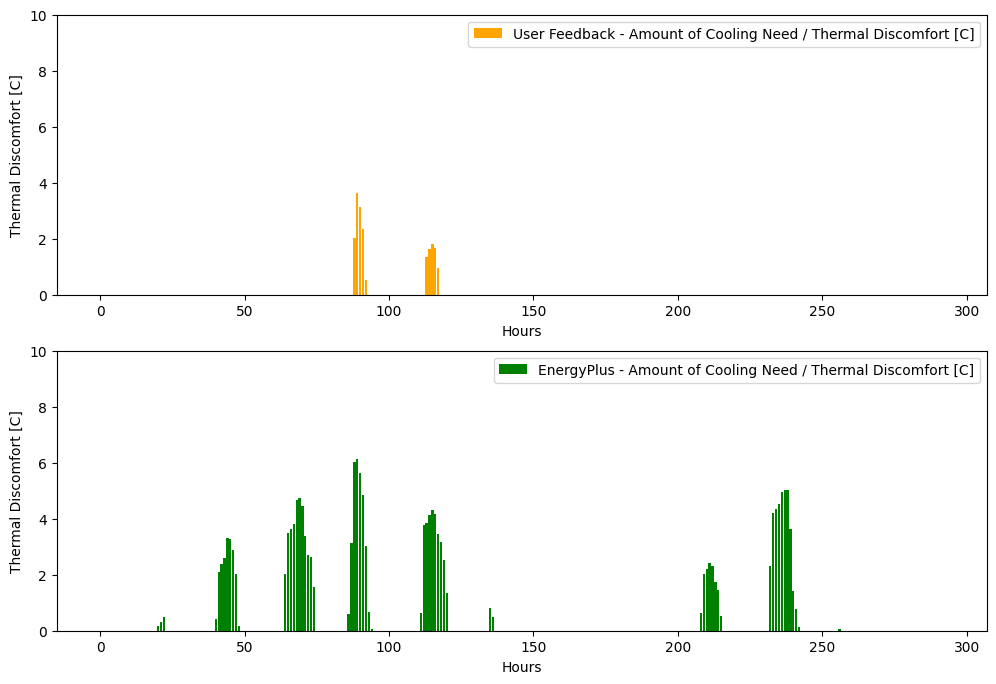

Sum of user feedback cooling load:  19.0
Sum of eplus cooling load:  170.0
Amount of hours where user feedback cooling load is higher than eplus cooling load:  0
Amount of hours where eplus cooling load is higher than user feedback cooling load:  64
Amount of hours where eplus cooling load is equal to user feedback cooling load:  229
Amount of hours where user feedback cooling load is higher than 0:  10
Amount of hours where eplus cooling load is higher than 0:  64


In [7]:
# in two subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].bar(range(len(cooling_load_user_feedback)), cooling_load_user_feedback, label="User Feedback - Amount of Cooling Need / Thermal Discomfort [C]", color='orange')
ax[0].set_ylabel('Thermal Discomfort [C]')
ax[0].set_xlabel('Hours')
ax[0].set_ylim(0, 10)  # Set y-axis limit
ax[0].legend()
ax[1].bar(range(len(cooling_load_eplus)), cooling_load_eplus, label="EnergyPlus - Amount of Cooling Need / Thermal Discomfort [C]", color='green')
ax[1].set_xlabel('hours')
ax[1].set_ylabel('Thermal Discomfort [C]')
ax[1].set_xlabel('Hours')
ax[1].set_ylim(0, 10)  # Set y-axis limit
ax[1].legend()
plt.show()

print("Sum of user feedback cooling load: ", round(np.sum(cooling_load_user_feedback), 0))
print("Sum of eplus cooling load: ", round(np.sum(cooling_load_eplus), 0))

# print the amount of hours where the cooling load is higher than the eplus cooling load
print("Amount of hours where user feedback cooling load is higher than eplus cooling load: ", np.sum(cooling_load_user_feedback > cooling_load_eplus))
print("Amount of hours where eplus cooling load is higher than user feedback cooling load: ", np.sum(cooling_load_user_feedback < cooling_load_eplus))
print("Amount of hours where eplus cooling load is equal to user feedback cooling load: ", np.sum(cooling_load_user_feedback == cooling_load_eplus))

# print the amount of hours where the cooling load higher 0 for each cooling load
print("Amount of hours where user feedback cooling load is higher than 0: ", np.sum(cooling_load_user_feedback > 0))
print("Amount of hours where eplus cooling load is higher than 0: ", np.sum(cooling_load_eplus > 0))


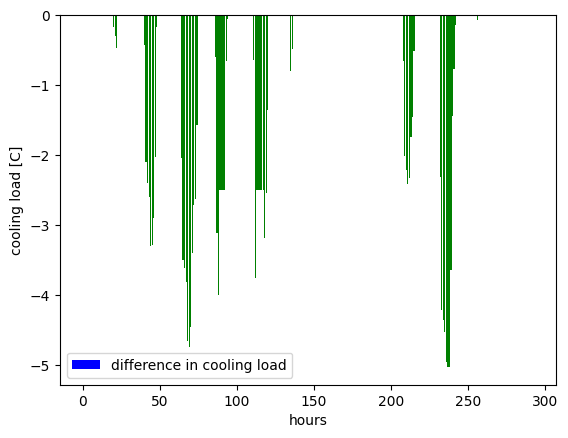

In [8]:
# the difference between the two cooling loads
# color the bars in red if the difference is positive (user feedback cooling load is higher than eplus cooling load)
# color the bars in green if the difference is negative (eplus cooling load is higher than user feedback cooling load)
# color the bars in blue if the difference is zero (eplus cooling load is equal to user feedback cooling load)

cooling_load_difference = cooling_load_user_feedback - cooling_load_eplus

# Determine the color for each bar
colors = ['red' if diff > 0 else 'green' if diff < 0 else 'blue' for diff in cooling_load_difference]

# Plot the bars with the specified colors
plt.bar(range(len(cooling_load_difference)), cooling_load_difference, color=colors, label="difference in cooling load")

plt.xlabel('hours')
plt.ylabel('cooling load [C]')
plt.legend()
plt.show()
